## Crowdfunding Campaign Success Prediction - Random Forest, Naive Bayes, SVMThe main goal of this micro project is to build and evaluate three machine learning models—Random Forest, Naive Bayes, and SVM—to predict the success of crowdfunding campaigns based on features like financial goals, funds raised, campaign duration, and backer engagement, and to determine which model performs best.

### 1. Data Preprocessing:
#### 1.1 Load the Dataset:

In [11]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ArchanaInsights/Datasets/refs/heads/main/crowdfunding_campaign.csv')

In [12]:
df.head()

,CampaignID,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates,IsSuccessful
0,CID_00000,76159,73518.028955,15,1903,Film,September,Australia,GBP,11,Yes,41758,3,0
1,CID_00001,69394,60068.683288,49,469,Art,October,Australia,GBP,7,Yes,79112,48,0
2,CID_00002,18652,22958.153470,58,148,Film,February,USA,EUR,17,No,3942,9,1
3,CID_00003,19487,24229.048390,39,780,Film,October,Germany,AUD,10,No,22047,35,1
4,CID_00004,26734,17984.630311,68,1622,Games,September,Australia,AUD,12,Yes,72568,17,0


In [13]:
df.shape

(100000, 14)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CampaignID           100000 non-null  object 
 1   GoalAmount           100000 non-null  int64  
 2   RaisedAmount         100000 non-null  float64
 3   DurationDays         100000 non-null  int64  
 4   NumBackers           100000 non-null  int64  
 5   Category             100000 non-null  object 
 6   LaunchMonth          100000 non-null  object 
 7   Country              100000 non-null  object 
 8   Currency             100000 non-null  object 
 9   OwnerExperience      100000 non-null  int64  
 10  VideoIncluded        100000 non-null  object 
 11  SocialMediaPresence  100000 non-null  int64  
 12  NumUpdates           100000 non-null  int64  
 13  IsSuccessful         100000 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 10.7+ MB


##### 1.2 Exploratory Data Analysis

In [16]:
df.drop(columns='IsSuccessful').describe().round(1)

,GoalAmount,RaisedAmount,DurationDays,NumBackers,OwnerExperience,SocialMediaPresence,NumUpdates
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,50538.0,50598.1,52.0,1003.3,9.5,50077.3,24.5
std,28613.8,33255.3,21.7,574.5,5.8,28767.5,14.4
min,1000.0,528.6,15.0,10.0,0.0,100.0,0.0
25%,25724.8,23396.5,33.0,505.0,4.0,25276.8,12.0
50%,50706.0,45980.7,52.0,1003.0,9.0,50024.5,25.0
75%,75316.0,72790.2,71.0,1502.0,14.0,74934.2,37.0
max,99999.0,149238.4,89.0,1999.0,19.0,99999.0,49.0


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

##### Box Plots across Features

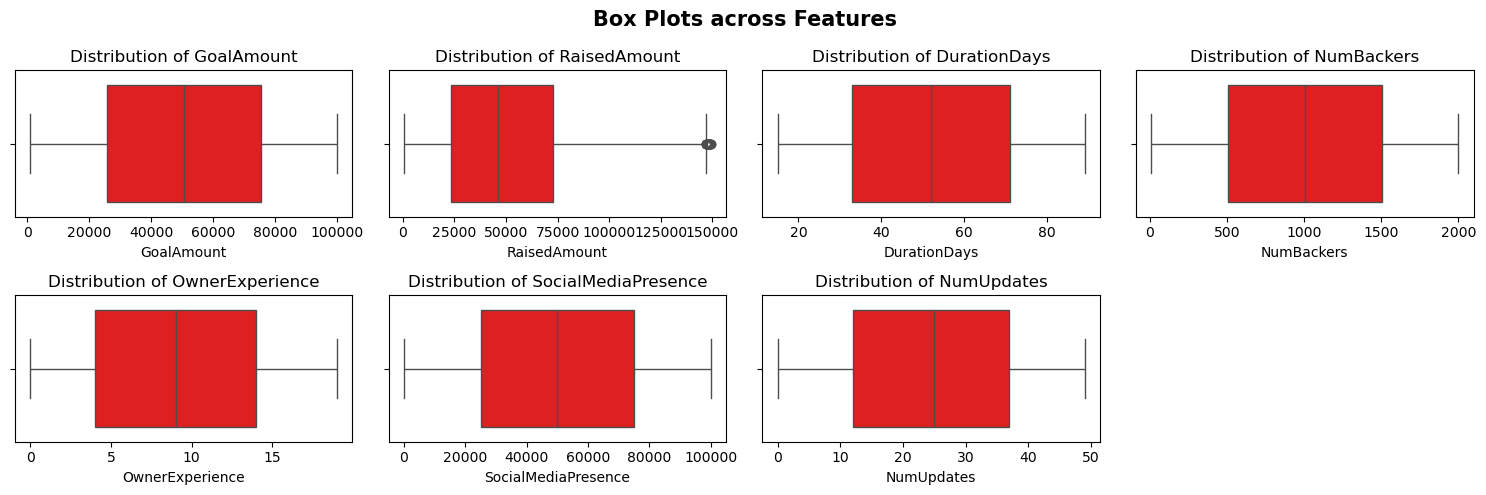

In [19]:
cat_col = df.drop('IsSuccessful', axis=1).select_dtypes(exclude='O').columns.to_list()

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.flatten()

for col, axis in zip(cat_col, axes):
    sns.boxplot(data=df, x=col, ax=axis, color='red')
    axis.set_title(f'Distribution of {col}')

axes[-1].set_visible(False)
plt.suptitle('Box Plots across Features', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

- The `Descriptive Statistics` and `Box Plots` of the numerical features indicate that our dataset is largely free from outliers, suggesting a consistent range of values across most attributes.
  
- While the `RaisedAmount` attribute does display a few outliers, these can be attributed to successful campaigns achieving higher funding through crowdfunding, which is feasible and realistic in this context.
  
- Thus, the presence of these higher values in `RaisedAmount` does not indicate data anomalies but rather reflects potential campaign successes.

##### Distribution of Successful Campaigns

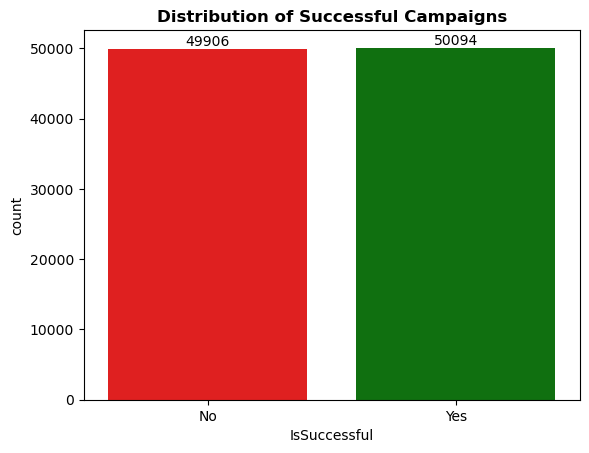

In [22]:
ax = sns.countplot(data=df, x='IsSuccessful', hue='IsSuccessful', legend=False, palette=['red', 'green'])
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribution of Successful Campaigns', fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

- From our dataset, we can observe that there is a 50% success rate, indicating that only half of the campaigns conducted are successful.

- It's a balanced Dataset which will make the Machine Learning model to learn effectively from the data.

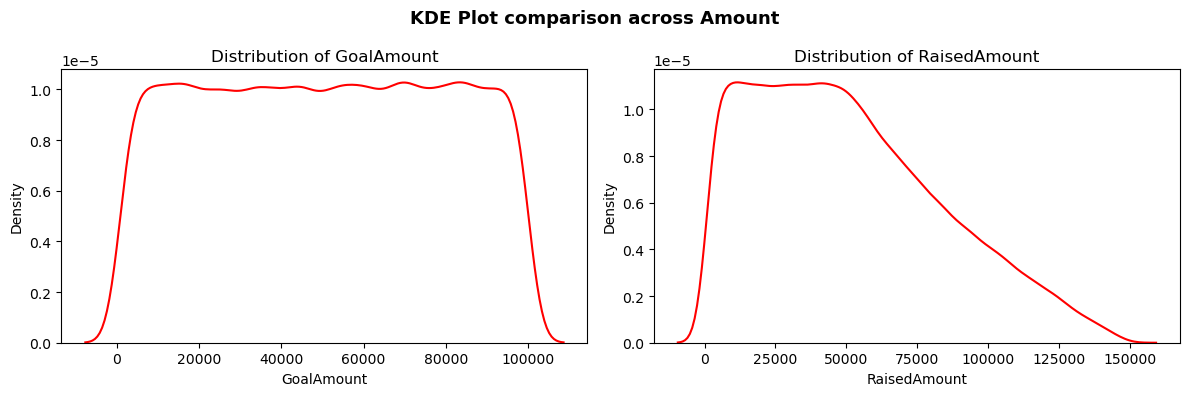

GoalAmount Skewness   :  -0.004 
RaisedAmount Skewness :  0.565


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for col, axis in zip(['GoalAmount', 'RaisedAmount'], axes):
    sns.kdeplot(data=df, x=col, ax=axis, color='red')
    axis.set_title(f'Distribution of {col}')


plt.suptitle('KDE Plot comparison across Amount', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print('GoalAmount Skewness   : ', df['GoalAmount'].skew().round(3), 
      '\nRaisedAmount Skewness : ', df['RaisedAmount'].skew().round(3))

- The Density Plots reveal that the `Goal Amount` follows a **normal distribution** with skewness **nearly equal to zero**, indicating a balanced spread around the mean.

- In contrast, the `Raised Amount` shows **right skewness** (positive skewness), likely due to **exceptionally high-performing campaigns** that create a skewed distribution towards the higher end.

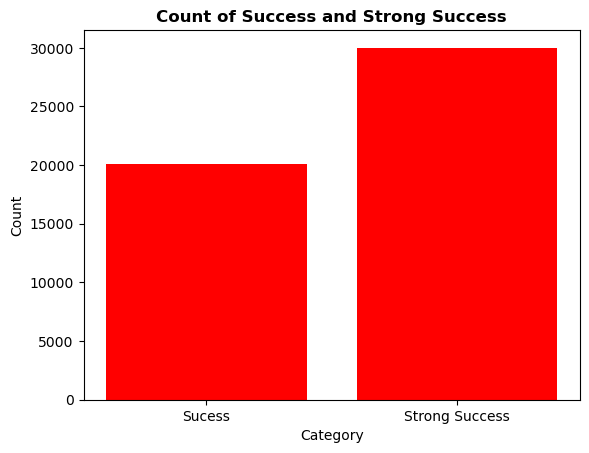

In [26]:
PercentageOfGoal = df['RaisedAmount'] / df['GoalAmount'] * 100
success = df[(PercentageOfGoal >= 100) & (PercentageOfGoal <= 120)]
strong_success = df[PercentageOfGoal > 120]

plt.bar(x=['Sucess', 'Strong Success'], height=[success.shape[0], strong_success.shape[0]], color='red')

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Count of Success and Strong Success", fontweight='bold')
plt.show()

- The campaigns were classified into two categories based on their `RaisedAmounts`: **Success (where 100% ≤ Raised Amount ≤ 120% of Goal Amount)** and **Strong Success (where Raised Amount > 120% of Goal Amount)**.

- The bar plot indicates that a **significant number of campaigns fall under the Strong Success category**, which explains the right-skewed distribution of the `Raised Amount`, as the high-performing campaigns contribute to the positive skew.

##### Count Plots across `Currency`, `Category`, `Country` by IsSuccessful:

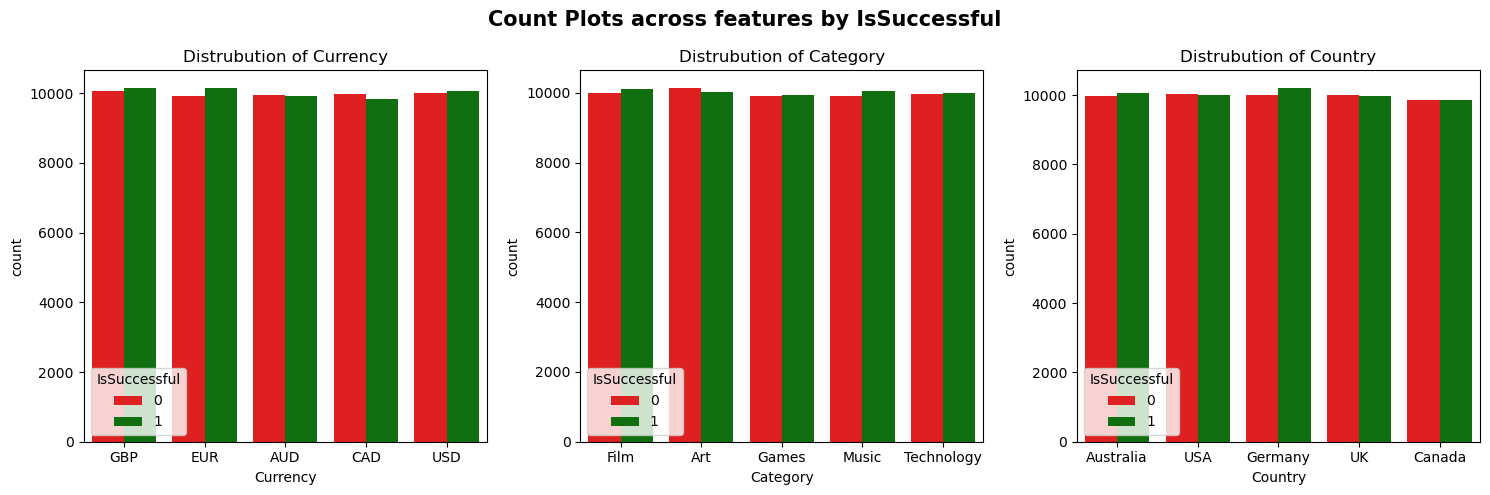

In [29]:
col = ['Currency', 'Category', 'Country']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for columns, axis in zip(col, axes):
    sns.countplot(data=df, x=columns, hue='IsSuccessful', ax=axis, palette=['red', 'green'])
    axis.set_title(f'Distrubution of {columns}')
    axis.legend(title='IsSuccessful', loc='lower left')

plt.suptitle('Count Plots across features by IsSuccessful', fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

- The `Count Plots` hued by `IsSuccessful` illustrate that successful campaign counts are evenly distributed across features such as `Currency`, `Category`, and `Country`.
  
- This even distribution suggests that the likelihood of a campaign's success does not vary significantly with these features, pointing to other possible factors that may influence campaign outcomes.
  
- `Germany` and `EUR` currency shows a bit high successfully campaigns compared to others but no significant differences. 

##### Successful Campaigns across LaunchMonth

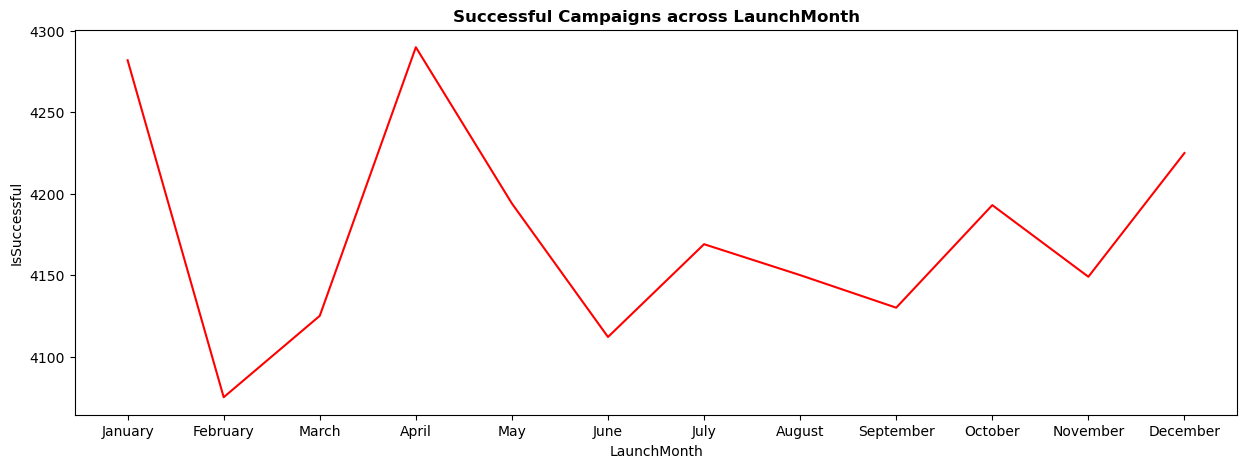

In [110]:
import calendar

plt.figure(figsize=(15, 5))
order = calendar.month_name[1:]
sns.lineplot(data=df, x='LaunchMonth', y='IsSuccessful', estimator='sum', color='red', errorbar=None)

plt.title('Successful Campaigns across LaunchMonth', fontweight='bold')
plt.xticks(ticks=range(len(order)), labels=order)
plt.show()

- We can observe that `April` has the highest count of `successful campaigns`, while `February` and `June` show noticeable declines.
  
- Success counts fluctuate over the year, with peaks in `January` and `April`, followed by dips in mid-year months like `June` and `September`.
  
- This pattern suggests that certain months may be more favorable for campaign success, possibly due to seasonal factors or timing preferences.

##### 1.3 Statistical Analysis

##### a. OwnerExperience by IsSuccessful
**Null Hypotheses :** `Experience` doesn't influences `Success`.<br>

**Alternate Hypotheses :** `Experience` negatively influences `Success`.

In [36]:
from scipy.stats import pointbiserialr

In [33]:
corr, p_value = pointbiserialr(df['IsSuccessful'], df['OwnerExperience'])
p_value_one_tailed = p_value / 2 if corr < 0 else 1 - (p_value / 2)
print('P Value One Tailed : ', p_value_one_tailed.round(3))

if p_value_one_tailed < 0.05:
    print("We reject the Null hypotheses! \nExperience negatively influences Success.")
else:
    print("We failed to reject the Null hypotheses! \nExperience doesn't influences Success.")

P Value One Tailed :  0.013
We reject the Null hypotheses! 
Experience negatively influences Success.


- The `Point-Biserial Correlation` statistical model provides strong evidence that the success of a campaign is significantly influenced by the `owner's experience`, highlighting the critical role that the owner's expertise and background play in driving campaign outcomes.

- Interestingly, **campaigns lead by oweners with low expertise shows a great performance** compared to owners with high experience. This was proven by the `One-Tailed Point-Biserial Correlation` statistical model.
  
- I Used `Point-Biserial Correlation` because I have a binary data (yes or no) and a continuous numerical data. `Point-Biserial Correlation` works better when it comes to test these kind of attributes.

##### b. SocialMediaPresence by IsSuccessful
**Null Hypotheses :** `Success` and `SocialMediaPresence` are independent.<br>

**Alternate Hypotheses :** `Success` and `SocialMediaPresence` are dependent.

In [36]:
corr, p_value = pointbiserialr(df['IsSuccessful'], df['SocialMediaPresence'])
print("P Value: ", p_value.round(3))

if p_value < 0.05:
    print("We reject the Null hypotheses! \nSuccess depends on Social Media Presence")
else:
    print("We failed to reject the Null hypotheses! \nSuccess independent of Social Media Presence")

P Value:  0.889
We failed to reject the Null hypotheses! 
Success independent of Social Media Presence


##### c. VideoIncluded by IsSuccessful
**Null Hypotheses :** `Success` and `VideoIncluded` are independent.<br>

**Alternate Hypotheses :** `Success` and `VideoIncluded` are dependent.

In [38]:
from scipy.stats import chi2_contingency

In [39]:
ci2_stats, p_value, dof, expected = chi2_contingency(pd.crosstab(df['VideoIncluded'], df['IsSuccessful']))
print("P Value: ", p_value.round(3))

if p_value < 0.05:
    print("We reject the Null hypotheses! \nSuccess depends on Video Included")
else:
    print("We failed to reject the Null hypotheses! \nSuccess independent of Video Inclution")

P Value:  0.378
We failed to reject the Null hypotheses! 
Success independent of Video Inclution


##### d. Currency by IsSuccessful
**Null Hypotheses :** `Success` and `Currency` are independent.<br>

**Alternate Hypotheses :** `Success` and `Currency` are dependent.

In [41]:
ci2_stats, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Currency'], df['IsSuccessful']))
print("P Value: ", p_value.round(3))

if p_value < 0.05:
    print("We reject the Null hypotheses! \nSuccess depends on Currency")
else:
    print("We failed to reject the Null hypotheses! \nSuccess independent of Currency")

P Value:  0.412
We failed to reject the Null hypotheses! 
Success independent of Currency


- The statistical tests provide strong evidence that the `success` of a crowdfunding campaign is highly influenced by the `owner's level of experience`.
  
- In contrast, factors such as the presence of the `campaign on social media`, the inclusion of a `campaign video`, or the `currency` in which the crowdfunding is conducted show **minimal impact on its success**.

#### 1.2 Handle Missing Values:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CampaignID           100000 non-null  object 
 1   GoalAmount           100000 non-null  int64  
 2   RaisedAmount         100000 non-null  float64
 3   DurationDays         100000 non-null  int64  
 4   NumBackers           100000 non-null  int64  
 5   Category             100000 non-null  object 
 6   LaunchMonth          100000 non-null  object 
 7   Country              100000 non-null  object 
 8   Currency             100000 non-null  object 
 9   OwnerExperience      100000 non-null  int64  
 10  VideoIncluded        100000 non-null  object 
 11  SocialMediaPresence  100000 non-null  int64  
 12  NumUpdates           100000 non-null  int64  
 13  IsSuccessful         100000 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 10.7+ MB


In [45]:
df.isnull().sum()

CampaignID             0
GoalAmount             0
RaisedAmount           0
DurationDays           0
NumBackers             0
Category               0
LaunchMonth            0
Country                0
Currency               0
OwnerExperience        0
VideoIncluded          0
SocialMediaPresence    0
NumUpdates             0
IsSuccessful           0
dtype: int64

In [46]:
categorical_columns = df.drop(columns='CampaignID').select_dtypes(include='O').columns
numerical_columns = df.drop(columns=['CampaignID', 'IsSuccessful']).select_dtypes(exclude='O').columns

for i in categorical_columns:
    print(f'{i}\n{df[i].unique()}\n')

Category
['Film' 'Art' 'Games' 'Music' 'Technology']

LaunchMonth
['September' 'October' 'February' 'April' 'June' 'July' 'March' 'January'
 'August' 'December' 'November' 'May']

Country
['Australia' 'USA' 'Germany' 'UK' 'Canada']

Currency
['GBP' 'EUR' 'AUD' 'CAD' 'USD']

VideoIncluded
['Yes' 'No']



- From the above observations we can conclude that there is no missing values and our dataset is ready for further analysis.

#### 1.3 Encode Categorical Features:

In [49]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.head()

,CampaignID,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates,IsSuccessful
0,CID_00000,76159,73518.028955,15,1903,1,11,0,3,11,1,41758,3,0
1,CID_00001,69394,60068.683288,49,469,0,10,0,3,7,1,79112,48,0
2,CID_00002,18652,22958.153470,58,148,1,3,4,2,17,0,3942,9,1
3,CID_00003,19487,24229.048390,39,780,1,10,2,0,10,0,22047,35,1
4,CID_00004,26734,17984.630311,68,1622,2,11,0,0,12,1,72568,17,0


#### 1.4 Feature Selection:

In [51]:
X = df.drop(columns=['CampaignID', 'IsSuccessful'])
y = df['IsSuccessful']

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit_transform(X, y)
scores = selector.scores_

f_score = pd.DataFrame({
    'Features' : X.columns, 
    'Scores' : scores.round(2)
        }).sort_values(by='Scores', ascending=False).reset_index(drop=True)
f_score

,Features,Scores
0,RaisedAmount,17295.63
1,OwnerExperience,4.92
2,GoalAmount,1.80
3,Currency,0.95
4,VideoIncluded,0.79
5,DurationDays,0.78
6,NumBackers,0.67
7,Category,0.39
8,Country,0.16
9,LaunchMonth,0.13


- From the above `Scores` given by `SelectKBest`, we can take only the `RaisedAmount` feature to build the model as it shows significantly high `Score` than others.

- But we have less amount of features in the dataset considering all will be right choice to increase the accuracy of the model prediction.

#### 1.5 Data Splitting:

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### 1.6 Feature Scaling:

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns]).round(3)
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns]).round(3)

In [58]:
X_train.head()

,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates
98980,-1.222,-1.007,-0.878,0.890,1,2,3,1,0.957,0,-1.663,-1.073
69824,-1.376,-1.101,0.925,1.592,2,7,1,2,-0.085,0,1.466,-1.143
9928,0.004,-0.357,0.324,-0.423,1,7,0,4,-1.647,0,1.351,-1.281
75599,-0.804,-1.040,-0.555,-0.970,4,2,1,2,0.957,1,-0.007,-1.073
95621,-1.647,-1.439,1.525,-0.951,1,1,2,3,1.130,1,0.277,1.353


In [65]:
X_test.head()

,GoalAmount,RaisedAmount,DurationDays,NumBackers,Category,LaunchMonth,Country,Currency,OwnerExperience,VideoIncluded,SocialMediaPresence,NumUpdates
75721,0.365,-0.412,-0.416,0.449,2,0,0,2,1.304,1,-0.584,0.382
80184,-1.375,-1.259,1.433,1.667,1,11,1,2,1.304,0,1.182,0.798
19864,-1.316,-1.110,0.416,-1.101,1,7,1,4,-1.647,0,-0.579,1.630
76699,0.470,-0.020,0.416,-1.022,0,8,1,1,-1.300,0,-0.085,1.283
92991,0.848,0.201,0.508,-0.263,4,1,0,2,-1.300,0,-0.553,-0.311


## 2. Ensemble Learning - Bagging (Bootstrap Aggregation)
### Random Forest - Model Building and Evaluation:
#### Model Building:

In [58]:
from sklearn.ensemble import RandomForestClassifier

metrics = pd.DataFrame(columns=['n_estimater', 'max_depth', 'Accuracy'])

for i in range(50, 201, 50):
    for j in range(5, 21, 5):
        clf = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=42)
        clf.fit(X_train, y_train)
        new_row = {'n_estimater': i, 'max_depth': j, 'Accuracy': f'{clf.score(X_test, y_test)*100:.2f}'}
        metrics = pd.concat([metrics, pd.DataFrame([new_row])], ignore_index=True)

#### Model Evaluation:

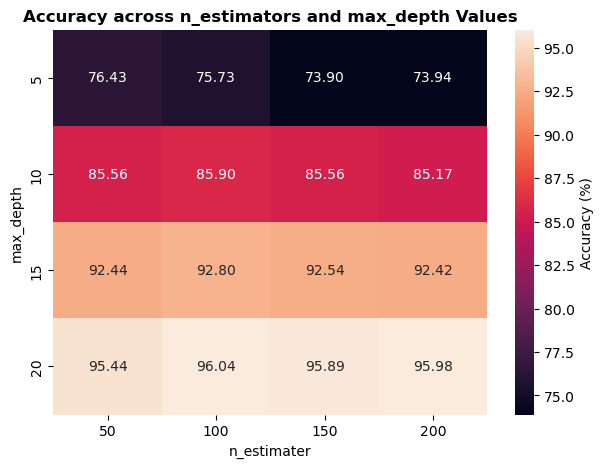

In [60]:
metrics.Accuracy = metrics.Accuracy.astype(float)
pivot_table = metrics.pivot(index="max_depth", columns="n_estimater", values='Accuracy')

plt.figure(figsize=(7, 5))
sns.heatmap(pivot_table, fmt='.2f', annot=True, cbar_kws={'label': 'Accuracy (%)'})

plt.title("Accuracy across n_estimators and max_depth Values", fontweight="bold")
plt.show()

- From the above heatmap we can conclude that, `n_estimators` > 100, accuracy decreased.

- Accuracy consistently increased when `max_depth` increased. Increasing the `max_depth` beyound 20 may leads to cause overfitting.

- Comparing `n_estimators` values of 50 and 100, `n_estimator = 100` and `max_depth = 20` shows best performance **(96.04)**. So we can build the model with these values.

## Ensemble Learning - Boosting
### AdaBoost (Adaptive Boosting)
#### Model Building:

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

metrics_ad = pd.DataFrame(columns=['max_depth', 'n_estimater', 'Accuracy'])

for i in range (2, 4):
    for j in range (50, 101, 50):
        base = DecisionTreeClassifier(max_depth=i)
        ada_model = AdaBoostClassifier(estimator=base, n_estimators=j, algorithm='SAMME')
        ada_model.fit(X_train, y_train)
        new_row = {'max_depth' : i, 'n_estimater' : j, 'Accuracy' : f'{ada_model.score(X_test, y_test)*100:.2f}'}
        metrics_ad = pd.concat([metrics_ad, pd.DataFrame([new_row])], ignore_index=True)

#### Model Evaluation:

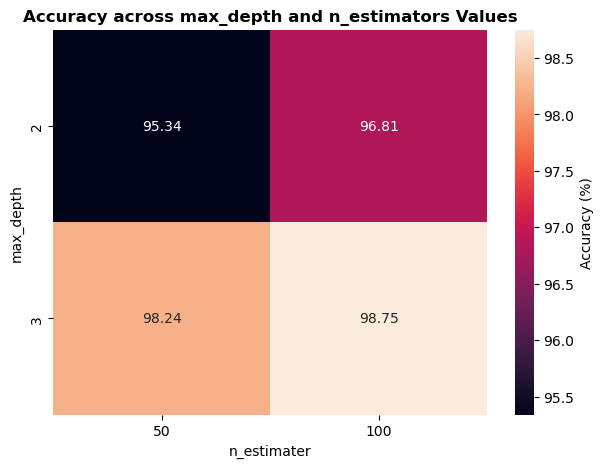

In [65]:
metrics_ad.Accuracy = metrics_ad.Accuracy.astype(float)
pivot_table = metrics_ad.pivot(index='max_depth', columns='n_estimater', values='Accuracy')

plt.figure(figsize=(7, 5))
sns.heatmap(data=pivot_table, annot=True, fmt='.2f', cbar_kws={'label' : 'Accuracy (%)'})

plt.title('Accuracy across max_depth and n_estimators Values', fontweight='bold')
plt.show()

- The above heatmap shows that `AdaBoost` algorithm shows high `Accuracy Score` of **98.75** with `max_depth = 3` and `n_estimator = 100`compared to `Random Forest` algorithm.

- Beyound Decision tree `max_depth = 3` and `n_estimator = 100` it may leads to overfitting. So, I stopped at this number.

### Gradient Boosting
#### Model Building:

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

accuracy  = []

for i in range(50, 301, 50):
    gb_model = GradientBoostingClassifier(n_estimators=i)
    gb_model.fit(X_train, y_train)
    accuracy.append(f'{gb_model.score(X_test, y_test)*100:.2f}')

#### Model Evaluation:

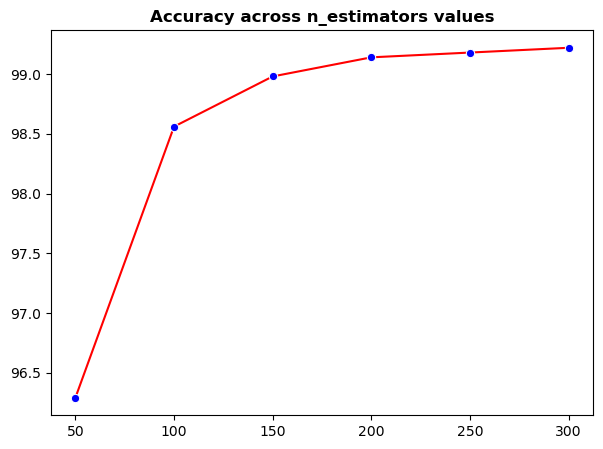

In [70]:
accuracy = list(map(float, accuracy))

plt.figure(figsize=(7, 5))
sns.lineplot(x=range(50, 301, 50), y=accuracy, marker='o', color='red', markerfacecolor='blue')

plt.title('Accuracy across n_estimators values', fontweight='bold')
plt.xticks(range(50, 301, 50))
plt.show()

- From the above line chart, Gradient Booting Alogorithm with `n_estimator = 300` shows an `Accuracy Score = 99.22 %` which is a bit effective compared with AdaBoost and Random Forest Algorithms.

- Beyound `n_estimator = 300` may cause overfitting and incresed the computation time.

### XGBoost (Extreme Gradient Boost)
#### Model Building:

In [73]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

metrics_xg = pd.DataFrame(columns=['max_depth', 'n_estimators', 'Accuracy'])

for i in range(3, 8):
    for j in range(100, 1001, 100):
        xg_model = xgb.XGBClassifier(n_estimators=j, max_depth=i, learning_rate=0.1)
        xg_model.fit(X_train, y_train)   
        y_pred = xg_model.predict(X_test)
        new_row = {'max_depth' : i, 'n_estimators' : j, 'Accuracy' : f'{accuracy_score(y_test, y_pred)*100:.2f}'}
        metrics_xg = pd.concat([metrics_xg, pd.DataFrame([new_row])], ignore_index=True)

#### Model Evaluation:

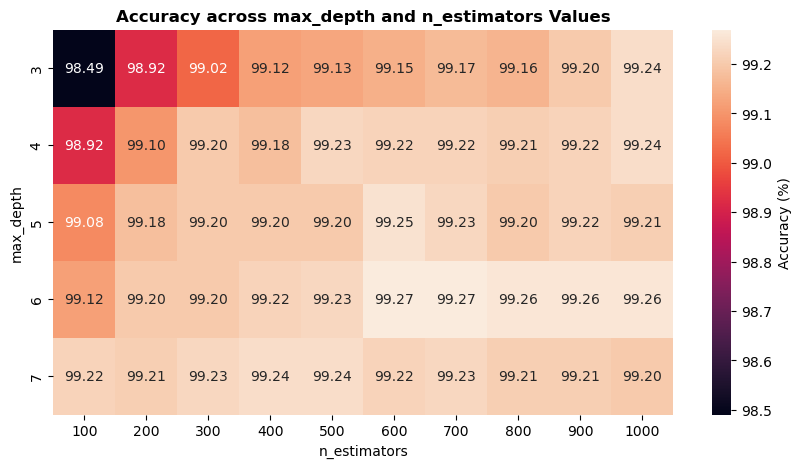

In [75]:
metrics_xg.Accuracy = metrics_xg.Accuracy.astype(float)
pivot_table = metrics_xg.pivot(index='max_depth', columns='n_estimators', values='Accuracy')

plt.figure(figsize=(10, 5))
sns.heatmap(data=pivot_table, annot=True, fmt='.2f', cbar_kws={'label' : 'Accuracy (%)'})

plt.title('Accuracy across max_depth and n_estimators Values', fontweight='bold')
plt.show()

- The optimal configuration appears to be `n_estimators = 600` and `max_depth = 6`, as it gives the highest accuracy **(99.27)** without unnecessary overfitting or diminishing returns in accuracy with higher numbers of estimators.

- It doesn't overfit as aggressively as max_depth = 7.

### 3. Naive Bayes - Model Building and Evaluation:
#### 3.1 Model Building:

In [89]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

#### 3.2 Model Evaluation:

In [95]:
from sklearn.metrics import accuracy_score

y_pred = nb_model.predict(X_test)
print(f'Accuracy Score = {accuracy_score(y_pred, y_test)*100:.2f} %')

Accuracy Score = 66.37 %


- GaussianNB model of **Accuracy Score of 66.37%** is very much lower compared to other ML models.

- As per our our dataset, choosing Naive Bayes algorithm is not preferable.

### 4. Support Vector Machine (SVM) - Model Building and Evaluation:
#### 4.1 Model Building:

In [95]:
from sklearn.svm import SVC

accuracy = []

for i in ['rbf', 'linear']:
    svm_model = SVC(kernel=i)
    svm_model.fit(X_train, y_train)
    accuracy.append(f'{svm_model.score(X_test, y_test)*100}')

#### 4.2 Model Evaluation:

In [99]:
accuracy = list(map(float, accuracy))

if accuracy[0] > accuracy[1]:
    print(f'SVM Model with Kernel Function of RBF Shows max accuracy of {accuracy[0]:.2f}')
else:
    print(f'SVM Model with Kernel Function of Linear Shows max accuracy of {accuracy[1]:.2f}')

SVM Model with Kernel Function of Linear Shows max accuracy of 99.87


- From the above we can conclude that Support Vector Classifier shows an `Accuracy Score = 99.87%` 

### 5. Comparison and Analysis:
#### 5.1 Compare the accuracy scores of the three models.
- On comparing the `Accuracy Scores` **Support Vector Machine** with `Kernel function = Linear` shows high accuracy of **99.87 %**.

- Extreme Gradient Boosting (XGBoost) shows an `Accuracy Score` of **99.27 %** which is closer to SVM's accuracy.

- Gaussian Naive Bayes shows the least `Accuracy Score` of **66.37 %**, showing it's not suitable these type of dataset.
#### 5.2 Discuss which model performed best and why, based on the accuracy scores and other relevant factors.
- As we have a large Dataset of `shape(100000, 14)`, if **Computation Time** and **Memory** are indeed not a concern, then **Support Vector Machine** is the best model.

- Practically, in real time **ensemble learning** particularly **Extreme Gradient Boosting (XGBoost)** is most preferable as it shows an high `Accuracy Score` of **99.27 %** compared to other models.
#### 5.3 Reflect on the strengths and weaknesses of each model in the context of this dataset.
- As we have a large Dataset of `shape(100000, 14)`, the large number of data points can demand substantial memory resources for **SVM**, especially in storing and processing the kernel matrix. If it not a concern SVM is best.

- **Random Forest** shows a good `Accuracy Score` but, when it comes to efficiency perspective, Extreme Gradient Boosting (XGBoost) is most powerfull.

- **Gaussian Naive Bayes** performs well in low-dimensional data (fewer features) because it assumes independence between features. While this independence assumption simplifies calculations, it may not hold up well for high-dimensional data with complex feature interactions.